Gerekli Kütüphaneler

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Verisetimiz Neye Benziyor

In [6]:
data = pd.read_csv("/content/penguins.csv")
data.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Veri Yükleme ve Hazırlık Fonksiyonu

In [7]:
def load_and_prepare_data(file_path):
    original_data = pd.read_csv(file_path)
    data = original_data.copy()

    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        if data[col].isnull().any():
            data[col] = data[col].fillna(data[col].median())

    scaler = MinMaxScaler()
    features = ['bill_length_mm', 'bill_depth_mm']
    data[features] = scaler.fit_transform(data[features])

    return data, scaler, original_data

Kullanıcıdan Giriş Alma Fonksiyonu

In [8]:
def get_input(prompt, min_val, max_val, is_int=False):
    while True:
        try:
            val = int(input(prompt)) if is_int else float(input(prompt))
            if min_val <= val <= max_val:
                return val
            print(f"Değer {min_val} ile {max_val} arasında olmalı.")
        except ValueError:
            print("Geçersiz giriş. Lütfen sayı girin.")

K-Means Kümeleme Fonksiyonu

In [9]:
def apply_kmeans(data, features, n_clusters=3):
    model = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    data['cluster'] = model.fit_predict(data[features])
    return model

K-Means Kümelemenin Doğruluğunu Hesaplama Fonksiyonu

In [10]:
def evaluate_kmeans_accuracy(data, cluster_to_species):
    predicted_labels = data['cluster'].map(cluster_to_species)
    accuracy = (predicted_labels == data['species']).mean() * 100

    print(f"K-Means Modeli Doğruluğu: {float(accuracy):.2f}%")

KNN Kümelemenin Doğruluğunu Hesaplama Fonksiyonu

In [11]:
def evaluate_knn_accuracy(model, data, features):
    predictions = model.predict(data[features])
    accuracy = accuracy_score(data['species'], predictions) * 100
    print(f"KNN Modeli Doğruluğu: {accuracy:.2f}%")

Yeni Verinin Sınıfını Tahmin Etme Fonksiyonu

In [12]:
def predict_new_data(new_point_scaled, data, features, kmeans_model, cluster_to_species, knn_model):
    new_df = pd.DataFrame([new_point_scaled], columns=features)

    cluster = kmeans_model.predict(new_df)[0]
    kmeans_species = cluster_to_species.get(cluster, "Bilinmeyen")

    knn_species = knn_model.predict(new_df)[0]

    print(f"K-Means tahmini: {kmeans_species}")
    print(f"KNN tahmini: {knn_species}")

    if kmeans_species == knn_species:
        print("Tahminler uyuştu.")
    else:
        print("Tahminler uyuşmuyor.")

Yeni Veri ile Görselleştirme Fonksiyonu

In [13]:
def plot_with_new_data(data, model, features, new_point_scaled, cluster_to_species):
    plt.figure(figsize=(8, 6))
    species_colors = {'Adelie': 'green', 'Chinstrap': 'red', 'Gentoo': 'black'}

    for cluster, species in cluster_to_species.items():
        cluster_data = data[data['cluster'] == cluster]
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]],
                    color=species_colors.get(species, 'gray'), label=species)

    plt.scatter(*model.cluster_centers_.T, color='purple', marker='*', label='Merkezler', s=200)
    plt.scatter(*new_point_scaled, color='blue', label='Yeni Veri', s=100, edgecolor='white')
    plt.xlabel('Gaga Uzunluğu (ölçeklenmiş)')
    plt.ylabel('Gaga Yüksekliği (ölçeklenmiş)')
    plt.title('Yeni Veri ile Görselleştirme')
    plt.legend()
    plt.grid(True)
    plt.show()

K-Means Tahmin Grafiği Çizim Fonksiyonu

In [14]:
def plot_kmeans_predictions(data, kmeans_model, features, cluster_to_species, new_point=None):
    colors = {'Adelie': 'green', 'Chinstrap': 'red', 'Gentoo': 'black'}

    data['kmeans_pred'] = data['cluster'].map(cluster_to_species)

    plt.figure(figsize=(8, 6))
    for species in data['kmeans_pred'].unique():
        subset = data[data['kmeans_pred'] == species]
        plt.scatter(subset[features[0]], subset[features[1]], color=colors[species], label=species)

    plt.scatter(*kmeans_model.cluster_centers_.T, color='purple', marker='*', s=200, label='K-Means Merkez')

    if new_point is not None:
        plt.scatter(*new_point, color='blue', label='Yeni Veri', s=100, edgecolor='white')

    plt.title('K-Means Kümeleme Tahminleri')
    plt.xlabel('Gaga Uzunluğu (ölçeklenmiş)')
    plt.ylabel('Gaga Yüksekliği (ölçeklenmiş)')
    plt.legend(title='Tür')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

KNN Tahmin Grafiği Çizim Fonksiyonu

In [15]:
def plot_knn_predictions(data, features, model, new_point=None):
    colors = {'Adelie': 'green', 'Chinstrap': 'red', 'Gentoo': 'black'}

    data['knn_pred'] = model.predict(data[features])

    plt.figure(figsize=(8, 6))
    for species in data['knn_pred'].unique():
        subset = data[data['knn_pred'] == species]
        plt.scatter(subset[features[0]], subset[features[1]], color=colors[species], label=species)

    if new_point is not None:
        plt.scatter(*new_point, color='blue', label='Yeni Veri', s=100, edgecolor='white')

    plt.title(f'KNN Sınıflandırma Tahminleri')
    plt.xlabel('Gaga Uzunluğu (ölçeklenmiş)')
    plt.ylabel('Gaga Yüksekliği (ölçeklenmiş)')
    plt.legend(title='Tür')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

K-Means ve KNN Confusion Matrix Oluşturma Fonksiyonu

In [16]:
def show_confusion_between_kmeans_knn(data):
    cm = confusion_matrix(data['kmeans_pred'], data['knn_pred'], labels=data['species'].unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data['species'].unique())
    disp.plot(cmap='Blues')
    plt.title("K-Means vs KNN Confusion Matrix")
    plt.grid(False)
    plt.show()

K-Means ve KNN Tahminlerinin Birbirine Uyumunu Hesaplayan Fonksiyon

In [17]:
def calculate_kmeans_knn_agreement(data):
    if 'kmeans_pred' not in data.columns or 'knn_pred' not in data.columns:
        print("Lütfen önce plot_kmeans_vs_knn fonksiyonunu çalıştırın.")
        return None

    total = len(data)
    match_count = (data['kmeans_pred'] == data['knn_pred']).sum()
    agreement_rate = (match_count / total) * 100

    print(f"K-Means ve KNN tahminlerinin uyum oranı: {agreement_rate:.2f}%")

Veri Yükleme ve İlk İşlemler

In [19]:
file_path = "/content/penguins.csv"
features = ['bill_length_mm', 'bill_depth_mm']

data, scaler, original_data = load_and_prepare_data(file_path)

kmeans_model = apply_kmeans(data, features)
cluster_to_species = data.groupby('cluster')['species'].agg(lambda x: x.mode()[0]).to_dict()

Kullanıcıdan Yeni Veri Alma

In [20]:
min_len = original_data['bill_length_mm'].min()
max_len = original_data['bill_length_mm'].max()

min_depth = original_data['bill_depth_mm'].min()
max_depth = original_data['bill_depth_mm'].max()

print(f"Gaga uzunluğu aralığı: {min_len:.1f} mm - {max_len:.1f} mm")
l = get_input("Gaga uzunluğu (mm): ", min_len, max_len)

print(f"Gaga yüksekliği aralığı: {min_depth:.1f} mm - {max_depth:.1f} mm")
d = get_input("Gaga yüksekliği (mm): ", min_depth, max_depth)

k = get_input("K değeri (1-10 arası): ", 1, 10, is_int=True)

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(data[features], data['species'])

new_data_df = pd.DataFrame([[l, d]], columns=features)
l_scaled, d_scaled = scaler.transform(new_data_df)[0]
new_point = (l_scaled, d_scaled)

Gaga uzunluğu aralığı: 32.1 mm - 59.6 mm
Gaga uzunluğu (mm): 50
Gaga yüksekliği aralığı: 13.1 mm - 21.5 mm
Gaga yüksekliği (mm): 19
K değeri (1-10 arası): 5


K-Means ve KNN Tahminleri Grafikleri

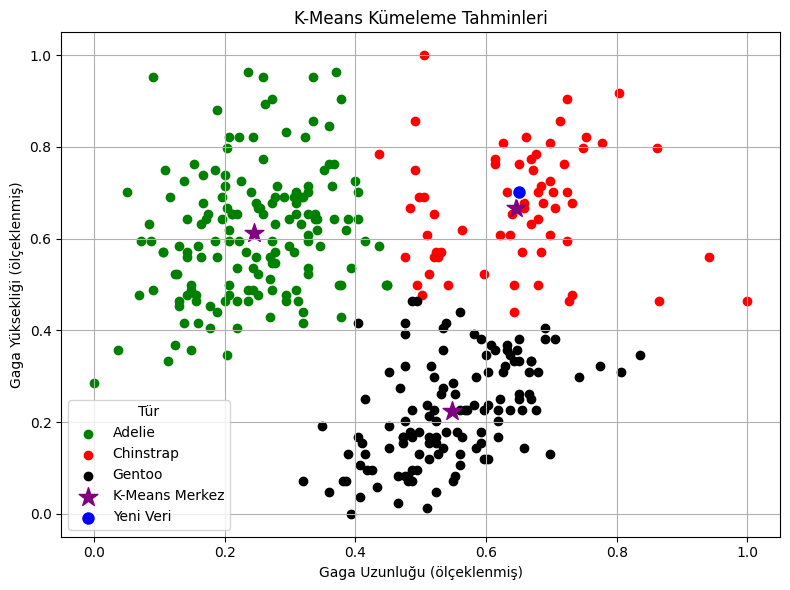

In [21]:
plot_kmeans_predictions(data, kmeans_model, features, cluster_to_species, new_point)

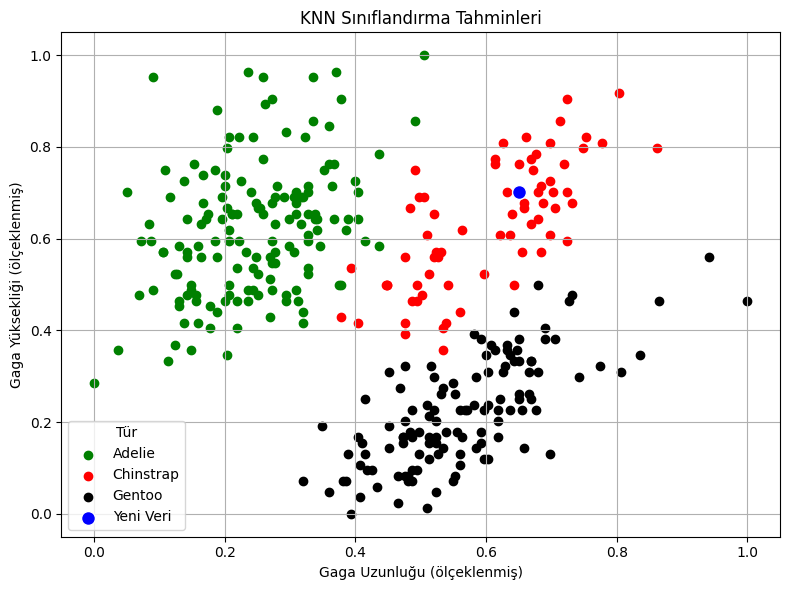

In [22]:
plot_knn_predictions(data, features, knn_model, new_point)

K-Means ve KNN Tahminlerinin Doğruluğu

In [23]:
evaluate_knn_accuracy(knn_model, data, features)
evaluate_kmeans_accuracy(data, cluster_to_species)

KNN Modeli Doğruluğu: 96.22%
K-Means Modeli Doğruluğu: 92.73%


Confusion Matrix Tablosu

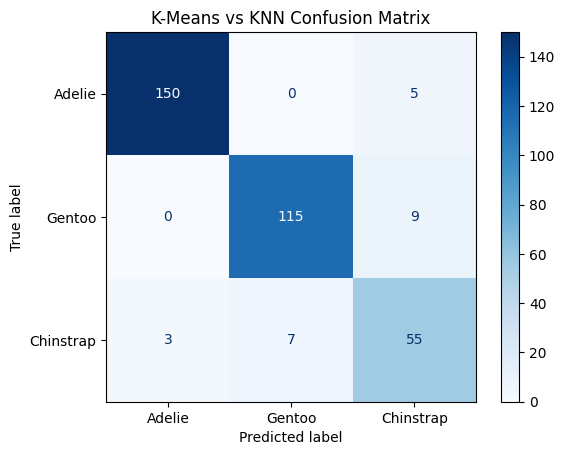

In [24]:
show_confusion_between_kmeans_knn(data)

K-Means ve KNN Tahminlerinin Birbirine Uyumu

In [25]:
calculate_kmeans_knn_agreement(data)

K-Means ve KNN tahminlerinin uyum oranı: 93.02%


Yeni Verinin K-Means ve KNN Tahminleri

In [26]:
predict_new_data(new_point, data, features, kmeans_model, cluster_to_species, knn_model)

K-Means tahmini: Chinstrap
KNN tahmini: Chinstrap
Tahminler uyuştu.
